# Set up + Initial Data Exploration

In [32]:
from tensorflow.keras import layers, regularizers, models, optimizers
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
from google.colab import drive
drive.mount('/content/drive')

!pip install cartopy
!pip install cftime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import cftime
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as patches

import tensorflow as tf
from tensorflow import keras

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 104.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.2 MB/s eta 0:00:00


Because Google Collab has a restricted enviornment, I am unable to import the data via HTTPS/SSL which is the only way the data can be accessed.

This is the code I ran to get the data on my machine, and then I downlaoded it locally and uploaded it to Google Drive to be used in Google Colab.

```
url = "https://climatedata.ibs.re.kr:9443/dods/public-data/cesm2-lens/ocn/TEMP/cesm2-lens-TEMP.1850-2100.mon.1x1"
ds = xr.open_dataset(url)
print(ds)
```

The CESM data description used for training and validation is [here](https://www.cesm.ucar.edu/community-projects/lens2).

To obtain ERA5 data, you must request the data based on the following parameters on [this](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=download) website.

Product type: Reanalysis
Variable: sea surface temperature
Years: 1980 to 2020
Months: Select all
Day: Select all
Time: Select all
Geographical area: Whole available region
Data format: NetCDF4
Download format: Unarchived

Similar to the CESM data, I downloaded it and uploaded it to be used in this Google Colab notebook.

In [3]:
# Load the dataset without decoding times
fn = '/content/drive/MyDrive/LargeEnsemble/LargeEnsemble/ENSO_SST/ENSO_SST/ENSO_Project_SST_r10i1181p1f1.nc'
enso = xr.open_dataset(fn, decode_times=False)

# Extract the time variable
time_var = enso['time']

# Convert the numeric time values to datetime objects
time_units = time_var.attrs['units']
calendar = time_var.attrs.get('calendar', 'noleap')
time_dates = cftime.num2date(time_var[:], units=time_units, calendar=calendar)

# Convert cftime.DatetimeNoLeap to pandas Timestamp
def cftime_to_datetime(cftime_obj):
    return pd.Timestamp(cftime_obj.isoformat())

# Apply the conversion
time_dates_standard = [cftime_to_datetime(t) for t in time_dates]
enso['time'] = ('time', time_dates_standard)
enso = enso.sel(time=slice('1959-01-01','2021-12-01'))

enso['SST']=(enso['SST']-273.15)  # Use the formula to get from C to F.

# Add some attributes as name:value pairs.
enso['SST'].attrs['long_name']='2m temperature'
enso['SST'].attrs['units']='Fahrenheit'
enso['SST'].attrs['formula']='(K-273.15) x 1.8 + 32'

# Slice to the Pacific Ocean
enso_po = enso.sel(lon=slice(130, 290), lat=slice(-30, 30))

# Calculate climatology
enso_clim = enso_po.groupby("time.month").mean('time')

# Calculate anomaly
enso_anoms = enso_po.groupby("time.month")-enso_clim

# Calculate area weighted mean for pacific ocean
weights = np.cos(np.deg2rad(enso_po.lat)); weights.name = "weights"
SSTa_global_mean = enso_anoms['SST'].weighted(weights).mean(dim=['lat','lon'])

# Global anomaly mean smoothed over many months
SSTa_global_mean_runningMean=SSTa_global_mean.rolling(time=12*5,center=True).mean()

# Detrend data
enso_detrended=(SSTa_global_mean-SSTa_global_mean_runningMean)

# Calcuate oceanic nino index (ONI) = 3 month rolling mean of SST anomaly
NINO34 = enso_anoms['SST'].weighted(weights).mean(dim=['lat','lon'])
ONI= NINO34.rolling(time=3,center=True).mean() # rolling mean over 3 months

Plot Time series of ONI and Detrended sea surface temperature anomalies in the pacific ocean.

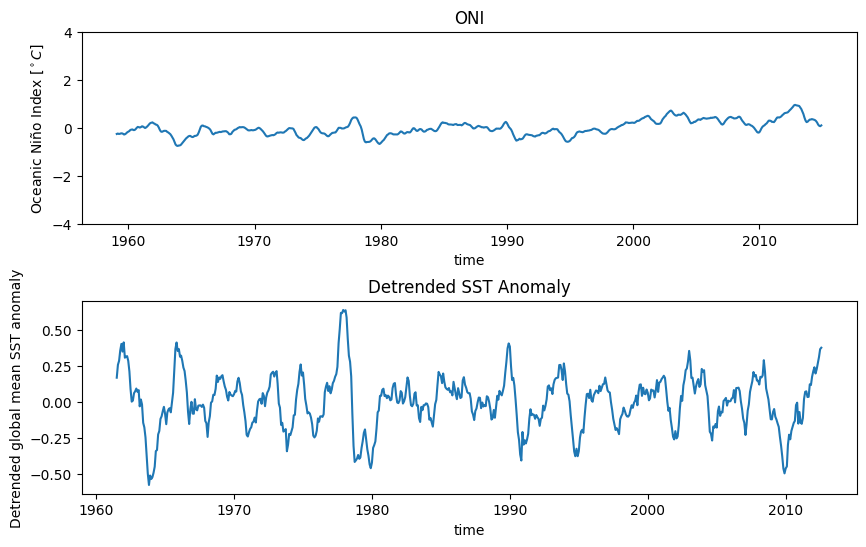

In [4]:
plt.figure(figsize=(10,6))

ax=plt.subplot(2,1,1)
ONI.plot(ax=ax)
plt.ylabel('Oceanic Niño Index [$^\circ C$]');plt.ylim((-4,4))
plt.title('ONI')
ax=plt.subplot(2,1,2)
enso_detrended.plot(ax=ax)
plt.ylabel("Detrended global mean SST anomaly")
plt.title('Detrended SST Anomaly')
plt.subplots_adjust(hspace=0.4)

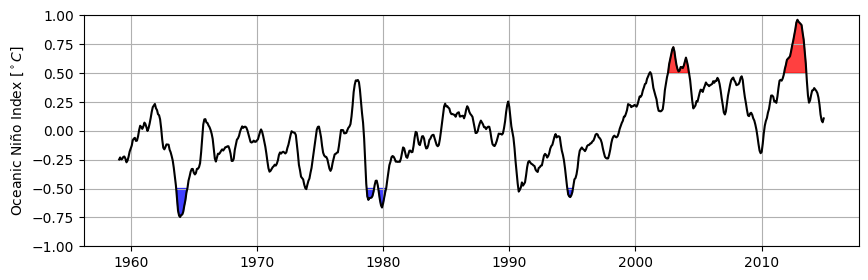

In [5]:
plt.figure(figsize=(10,3))
ax=plt.gca()
plt.plot(ONI.time, ONI,'k')
ax.fill_between(ONI.time.data, 0.5, ONI, ONI> 0.5, color='red', alpha=.75)
ax.fill_between(ONI.time.data, -0.5, ONI, ONI< -0.5, color='blue',  alpha=.75)
plt.ylim((-1,1))
plt.grid(visible=True)
plt.ylabel('Oceanic Niño Index [$^\circ C$]');

Text(0, 0.5, 'Time')

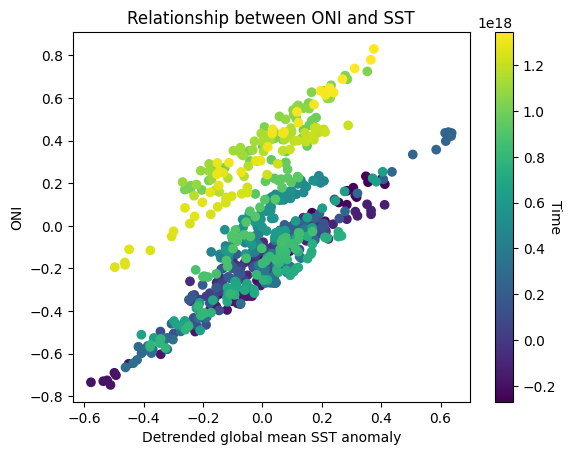

In [6]:
plt.scatter(enso_detrended,ONI,c=ONI.time)
plt.xlabel('Detrended global mean SST anomaly')
plt.ylabel("ONI")
plt.title("Relationship between ONI and SST")
cbar = plt.colorbar()
cbar.ax.set_ylabel('Time', rotation=270)


# Get X and Y

In [7]:
### Function for enso climatology data

def get_climatology_data(fld, run):
    fn = f'/content/drive/MyDrive/LargeEnsemble/LargeEnsemble/ENSO_{fld}/ENSO_{fld}/ENSO_Project_{fld}_{run}p1f1.nc'
    enso = xr.open_dataset(fn, decode_times=False)

    time_var = enso['time']
    time_units = time_var.attrs['units']
    calendar = time_var.attrs.get('calendar', 'noleap')
    time_dates = cftime.num2date(time_var[:], units=time_units, calendar=calendar)

    time_dates_standard = [cftime_to_datetime(t) for t in time_dates]
    enso['time'] = ('time', time_dates_standard)

    enso = enso.sel(time=slice('1959-01-01','2021-12-01'))

    enso_po = enso.sel(lon=slice(120, 290), lat=slice(-30, 30))

    enso_clim = enso_po.groupby("time.month").mean('time')
    enso_anoms = enso_po.groupby("time.month")-enso_clim

    weights = np.cos(np.deg2rad(enso_po.lat)); weights.name = "weights"
    global_mean = enso_anoms[fld].weighted(weights).mean(dim=['lat','lon'])
    global_mean_runningMean=global_mean.rolling(time=12*5,center=True).mean()
    enso_detrended=(global_mean-global_mean_runningMean)


    return enso, enso_po, enso_clim, enso_anoms, enso_detrended

# Get all climatology data and store in dictionary all_enso
# all_enso[run][fld]['enso_po'] to get data for example

runs = ['r10i1181', 'r9i1161', 'r8i1141', 'r7i1121', 'r6i1101', 'r5i1081', 'r4i1061', 'r3i1041', 'r2i1021', 'r1i1001']
flds = ['SST', 'PSL', 'U10', 'PRECT']
all_enso = {}

for run in runs:
    all_enso[run] = {}
    for fld in flds:
        enso, enso_po, enso_clim, enso_anoms, enso_detrended = get_climatology_data (fld, run)
        all_enso[run][fld] = {'enso': enso, 'enso_po': enso_po,'enso_clim': enso_clim,'enso_anoms': enso_anoms, 'enso_detrended':enso_detrended}

In [8]:
all_enso['r10i1181']['SST']

{'enso': <xarray.Dataset> Size: 17MB
 Dimensions:    (lat: 64, lon: 96, time: 673)
 Coordinates:
   * lat        (lat) float64 512B -89.06 -86.23 -83.4 ... 83.4 86.23 89.06
   * lon        (lon) float64 768B 1.25 5.0 8.75 12.5 ... 346.2 350.0 353.8 357.5
   * time       (time) datetime64[ns] 5kB 1959-01-01 1959-02-01 ... 2015-01-01
     member_id  <U12 48B ...
 Data variables:
     SST        (time, lat, lon) float32 17MB ...,
 'enso_po': <xarray.Dataset> Size: 3MB
 Dimensions:    (lat: 22, lon: 46, time: 673)
 Coordinates:
   * lat        (lat) float64 176B -29.69 -26.86 -24.03 ... 24.03 26.86 29.69
   * lon        (lon) float64 368B 121.2 125.0 128.8 132.5 ... 282.5 286.2 290.0
   * time       (time) datetime64[ns] 5kB 1959-01-01 1959-02-01 ... 2015-01-01
     member_id  <U12 48B ...
 Data variables:
     SST        (time, lat, lon) float32 3MB ...,
 'enso_clim': <xarray.Dataset> Size: 50kB
 Dimensions:    (month: 12, lat: 22, lon: 46)
 Coordinates:
   * lat        (lat) float64 176B

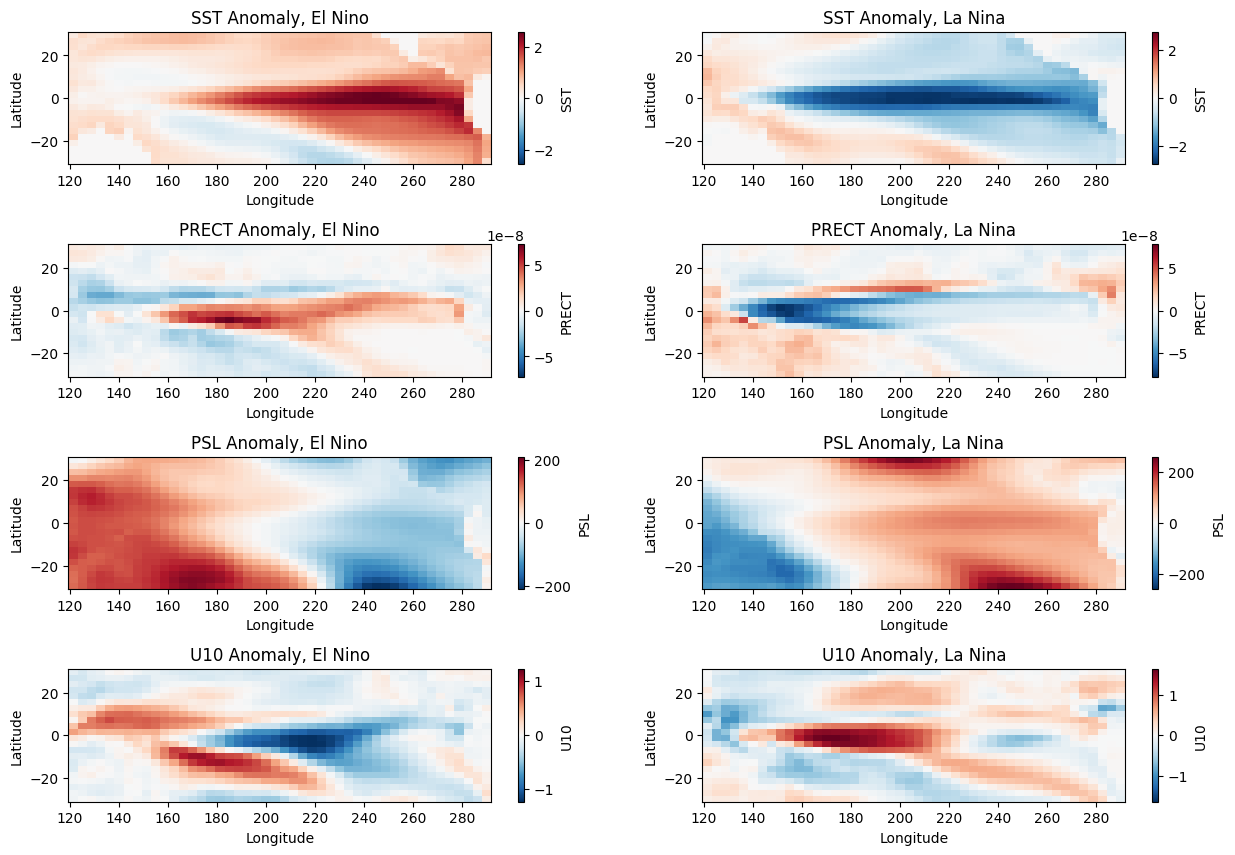

In [9]:
el_nino = ONI > 0.5
la_nina = ONI < -0.5

sst_anom_el_nino = all_enso['r10i1181']['SST']['enso_anoms'].SST[el_nino].mean('time')
sst_anom_la_nina = all_enso['r10i1181']['SST']['enso_anoms'].SST[la_nina].mean('time')

pr_anom_el_nino = all_enso['r10i1181']['PRECT']['enso_anoms'].PRECT[el_nino].mean('time')
pr_anom_la_nina = all_enso['r10i1181']['PRECT']['enso_anoms'].PRECT[la_nina].mean('time')

psl_anom_el_nino = all_enso['r10i1181']['PSL']['enso_anoms'].PSL[el_nino].mean('time')
psl_anom_la_nina = all_enso['r10i1181']['PSL']['enso_anoms'].PSL[la_nina].mean('time')

u10_anom_el_nino = all_enso['r10i1181']['U10']['enso_anoms'].U10[el_nino].mean('time')
u10_anom_la_nina = all_enso['r10i1181']['U10']['enso_anoms'].U10[la_nina].mean('time')


fig, ax = plt.subplots(4, 2,figsize=(15, 10))
plt.subplots_adjust(wspace=0.2, hspace=0.6)

sst_anom_el_nino.plot(ax = ax[0, 0])
ax[0, 0].set_xlabel('Longitude')
ax[0, 0].set_ylabel('Latitude')
ax[0, 0].set_title('SST Anomaly, El Nino')

sst_anom_la_nina.plot(ax = ax[0, 1])
ax[0, 1].set_xlabel('Longitude')
ax[0, 1].set_ylabel('Latitude')
ax[0, 1].set_title('SST Anomaly, La Nina')

pr_anom_el_nino.plot(ax = ax[1, 0])
ax[1, 0].set_xlabel('Longitude')
ax[1, 0].set_ylabel('Latitude')
ax[1, 0].set_title('PRECT Anomaly, El Nino')

pr_anom_la_nina.plot(ax = ax[1, 1])
ax[1, 1].set_xlabel('Longitude')
ax[1, 1].set_ylabel('Latitude')
ax[1, 1].set_title('PRECT Anomaly, La Nina')

psl_anom_el_nino.plot(ax = ax[2, 0])
ax[2, 0].set_xlabel('Longitude')
ax[2, 0].set_ylabel('Latitude')
ax[2, 0].set_title('PSL Anomaly, El Nino')

psl_anom_la_nina.plot(ax = ax[2, 1])
ax[2, 1].set_xlabel('Longitude')
ax[2, 1].set_ylabel('Latitude')
ax[2, 1].set_title('PSL Anomaly, La Nina')

u10_anom_el_nino.plot(ax = ax[3, 0])
ax[3, 0].set_xlabel('Longitude')
ax[3, 0].set_ylabel('Latitude')
ax[3, 0].set_title('U10 Anomaly, El Nino')

u10_anom_la_nina.plot(ax = ax[3, 1])
ax[3, 1].set_xlabel('Longitude')
ax[3, 1].set_ylabel('Latitude')
ax[3, 1].set_title('U10 Anomaly, La Nina')

plt.savefig('enso_climatology.jpeg', dpi=500)

## Prepare Input and Output

### Input: Sea surface temperature

In [10]:
# make function for getting testing data for CNN - combine 9 of the ensemble members

def get_testing_data(fld):
  runs = ['r1i1001', 'r2i1021', 'r3i1041', 'r4i1061', 'r5i1081', 'r6i1101', 'r7i1121', 'r8i1141', 'r9i1161', 'r10i1181']

  arrays = []

  for i, run in enumerate(runs):
    array = all_enso[run][fld]['enso_anoms']
    array = array.expand_dims('ensemble_member')
    array['ensemble_member'] = [f'm{i+1}']
    arrays.append(array)

# Concatenate all the DataArrays along the 'ensemble_member' dimension
  test_data = xr.concat(arrays, dim='ensemble_member')
  return test_data

In [11]:
# Get training/validation data
cesm_data = get_testing_data('SST')

### Output: Oceanic Nino Index

In [12]:
oni_test_data =[]
ensemble_m = ['m1','m2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10']

for m in ensemble_m:
    weights = np.cos(np.deg2rad(cesm_data.sel(ensemble_member=m).lat)); weights.name = "weights" # area of the cell scales as dlat*dlon*cos(lat) and we can use it to compute weighted averages; note, dlat=dlon for this dataset.
    NINO34 = cesm_data.sel(ensemble_member=m).weighted(weights).mean(dim=['lat','lon'])
    ONI= NINO34.rolling(time=3,center=True).mean() # rolling mean over 3 months
    oni_test_data.append(ONI)

## Finalizing Input and Output
I decided to use inputs of previous times, up to 2 years in intervals of 3 months which adds 9 (8 + 1) additional channels.

In [13]:
Nsamples = 673  # Since we have 673 months in the data

Input = np.zeros((Nsamples,len(ensemble_m), cesm_data.SST.shape[2], cesm_data.SST.shape[3], 9))
Output = np.zeros((Nsamples, len(ensemble_m), 12))
persistence = np.zeros((Nsamples,len(ensemble_m),12))

m_num=0
for m in ensemble_m:
  for i in range(Nsamples):
      # Randomly Select time index
      t0 = np.random.randint(3, cesm_data.sel(ensemble_member=m).SST.shape[0]-13)

      # Extract past SST anomalies from different time lags (t-3 months,
      # t-6 months, etc.) as our input
      Input[i,m_num,:,:,0] = cesm_data.sel(ensemble_member=m).SST[t0]
      Input[i,m_num,:,:,1] = cesm_data.sel(ensemble_member=m).SST[t0-3]
      Input[i,m_num,:,:,2] = cesm_data.sel(ensemble_member=m).SST[t0-6]
      Input[i,m_num,:,:,3] = cesm_data.sel(ensemble_member=m).SST[t0-9]
      Input[i,m_num,:,:,4] = cesm_data.sel(ensemble_member=m).SST[t0-12]
      Input[i,m_num,:,:,5] = cesm_data.sel(ensemble_member=m).SST[t0-15]
      Input[i,m_num,:,:,6] = cesm_data.sel(ensemble_member=m).SST[t0-18]
      Input[i,m_num,:,:,7] = cesm_data.sel(ensemble_member=m).SST[t0-21]
      Input[i,m_num,:,:,8] = cesm_data.sel(ensemble_member=m).SST[t0-24]

      # Extract future ONI values as our output
      Output[i,m_num,:] = oni_test_data[m_num].SST.isel(time=slice(t0+1,t0+13))

  m_num+=1


In [14]:
print(f'Input Size: {len(Input)} and Output Size: {len(Output)}')

Input Size: 673 and Output Size: 673


## Split Training and Validation data

In [15]:
# Training Data (Ensemble members 2 to 10)
X_train=Input[:,1:,:,:,:]
Y_train=Output[:,1:,:]

X_train = X_train.reshape(673 * 9, 22, 46, 9)
Y_train = Y_train.reshape(673 * 9, 12)

# Validation Data (Ensemble member 1)
X_val = Input[:,0,:,:,:]
Y_val = Output[:,0,:]
persistence_1 = persistence[:,0,:]

print(f'X Validation Size: {X_val.shape}')
print(f'Y Validation Size: {Y_val.shape}')

print(f'X Training Size: {X_train.shape}')
print(f'Y Training Size: {Y_train.shape}')

X Validation Size: (673, 22, 46, 9)
Y Validation Size: (673, 12)
X Training Size: (6057, 22, 46, 9)
Y Training Size: (6057, 12)


## Testing data

In [16]:
# Import data
era = xr.open_dataset('/content/drive/MyDrive/Datasets2023/ERA5/ERA5_Coarse.nc')

# Data Cleaning
era['sst']=(era['t2m']-273.15)
era['sst'].attrs['long_name']='2m temperature'
era['sst'].attrs['units']='Celcius'
era['sst'].attrs['formula']='(K-273.15)'
era = era.rename({'latitude': 'lat', 'longitude': 'lon'})
era = era.sel(lat=slice(None, None, -1))
era_interp = era['sst'].interp(lat=enso.lat, lon=enso.lon, time=enso.time, method='linear')
era_interp_po = era_interp.sel(lon=slice(120, 290), lat=slice(-30, 30))

# Calculate climatology and anomaly
era_clim = era_interp_po.groupby("time.month").mean('time')
era_anoms = era_interp_po.groupby("time.month")- era_clim

# Calculate ONI
oni_test_data =[]
weights = np.cos(np.deg2rad(era_anoms.lat)); weights.name = "weights"
NINO34 = era_anoms.weighted(weights).mean(dim=['lat','lon'])
ONI= NINO34.rolling(time=3,center=True).mean() #rolling mean over 3 months
oni_test_data.append(ONI)

Nsamples = 673

era_input = np.zeros((Nsamples, 1, era_anoms.shape[1], era_anoms.shape[2], 9))
era_output = np.zeros((Nsamples, 1, 12))
persistence = np.zeros((Nsamples, 1 ,12))

for i in range(Nsamples):
  # Randomly Select time index
  t0 = np.random.randint(3, era_anoms.shape[0] - 13)

  # Extract past SST anomalies from different time lags (t-3 months,
  # t-6 months, etc.) as our input
  era_input[i, 0, :, :, 0] = era_anoms[t0]
  era_input[i,0, :,:,1] = era_anoms[t0-3]
  era_input[i,0, :,:,2] = era_anoms[t0-6]
  era_input[i,0, :,:,3] = era_anoms[t0-9]
  era_input[i,0, :,:,4] = era_anoms[t0-12]
  era_input[i,0, :,:,5] = era_anoms[t0-15]
  era_input[i, 0,:,:,6] = era_anoms[t0-18]
  era_input[i,0, :,:,7] = era_anoms[t0-21]
  era_input[i, 0, :,:,8] = era_anoms[t0-24]

  # Extract future ONI values as our output
  era_output [i,0,:] = oni_test_data[0].isel(time=slice(t0+1,t0+13))

X_test = era_input[:,0,:,:,:]
Y_test = era_output[:,0,:]

print(f'X Test Size: {X_test.shape}')
print(f'Y Test Size: {Y_test.shape}')

X Test Size: (673, 22, 46, 9)
Y Test Size: (673, 12)


# Baseline Model

 Python code for the baseline MLP model

In [37]:
def baseline_model(input_shape,output_shape):
    x = keras.layers.Input(shape=input_shape)
    y = keras.layers.Flatten()(x)

    # Dense layers
    y = keras.layers.Dense(64, activation='relu')(y)
    y = keras.layers.Dense(32, activation='relu')(y)
    y = keras.layers.Dense(output_shape, activation='linear')(y)

    model = keras.models.Model(inputs=x, outputs=y)
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    return model

In [38]:
base = baseline_model(input_shape=(cesm_data.SST.shape[2], cesm_data.SST.shape[3], 9), output_shape = 12)
base.summary()

# format X and Y
X_train_stacked = X_train.reshape(673 * 9, 22, 46, 9)
Y_train_stacked = Y_train.reshape(673 * 9, 12)

# train the model, and save the progress to hist (hist will be a dictionary)
n_epochs = 20
hist = base.fit(x = X_train_stacked, y = Y_train_stacked,
               epochs=n_epochs, batch_size=512,
               validation_data=(X_val,Y_val),verbose=1)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 22, 46, 9)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9108)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │       582,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 585,452 (2.23 MB)

 Trainable params: 585,452 (2.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.1420 - loss: 0.9080 - val_accuracy: 0.1055 - val_loss: 0.2770
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.0921 - loss: 0.2089 - val_accuracy: 0.0951 - val_loss: 0.1293
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.0992 - loss: 0.0891 - val_accuracy: 0.0788 - val_loss: 0.0760
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.0851 - loss: 0.0531 - val_accuracy: 0.0921 - val_loss: 0.0603
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.0926 - loss: 0.0396 - val_accuracy: 0.0906 - val_loss: 0.0576
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.1027 - loss: 0.0325 - val_accuracy: 0.0966 - val_loss: 0.0501
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.1049 - loss: 0.0271 - val_accuracy: 0.0996 - val_loss: 0.0485
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.0999 - loss: 0.0237 - val_accuracy: 0.1070 - 

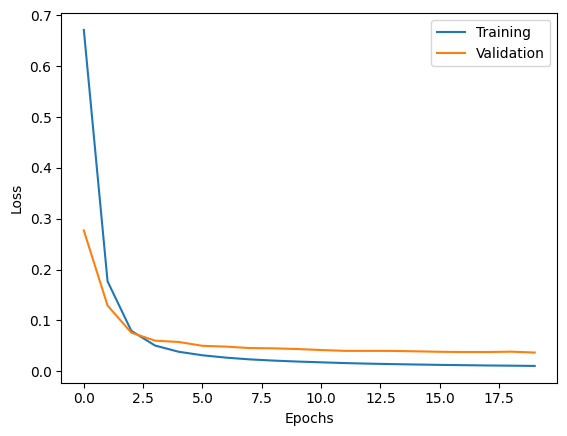

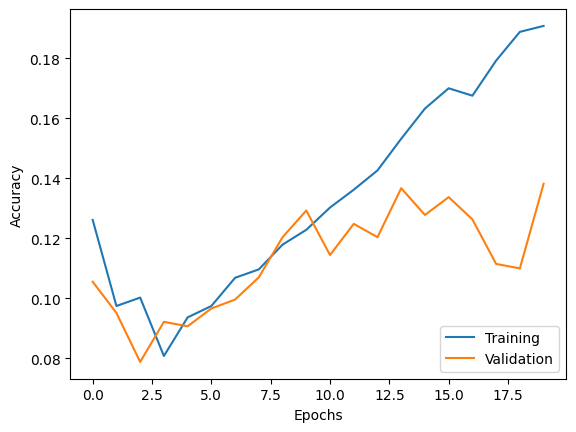

In [39]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(hist)

In [40]:
print(base.evaluate(X_test, Y_test))

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1048 - loss: 0.0625
[0.06247251480817795, 0.10252600163221359]


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Horizon 1 months -> RMSE: 0.045, MAE: 0.165
Horizon 2 months -> RMSE: 0.042, MAE: 0.162
Horizon 3 months -> RMSE: 0.081, MAE: 0.227
Horizon 4 months -> RMSE: 0.055, MAE: 0.186
Horizon 5 months -> RMSE: 0.050, MAE: 0.182
Horizon 6 months -> RMSE: 0.063, MAE: 0.203
Horizon 7 months -> RMSE: 0.079, MAE: 0.227
Horizon 8 months -> RMSE: 0.058, MAE: 0.190
Horizon 9 months -> RMSE: 0.066, MAE: 0.205
Horizon 10 months -> RMSE: 0.073, MAE: 0.209
Horizon 11 months -> RMSE: 0.073, MAE: 0.209
Horizon 12 months -> RMSE: 0.064, MAE: 0.205


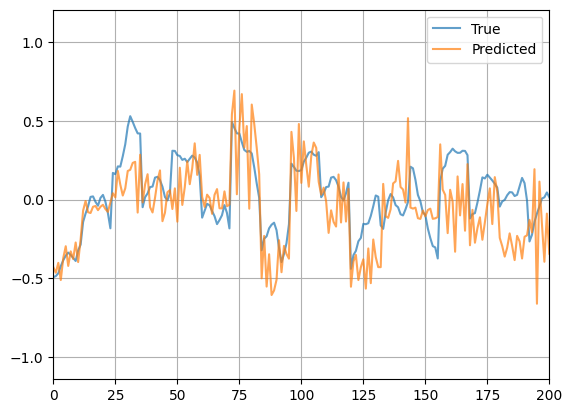

In [55]:
Y_pred = base.predict(X_test)  # Y prediction

# Calculate rmse and mae
for h in np.arange(1,13,1):
    y_true_h = Y_test[:, h-1]
    y_pred_h = Y_pred[:, h-1]
    rmse = mean_squared_error(y_true_h, y_pred_h)
    mae = mean_absolute_error(y_true_h, y_pred_h)
    print(f"Horizon {h} months : RMSE: {rmse:.3f}, MAE: {mae:.3f}")


# flatten Y
y_test_flat = Y_test.flatten()
y_pred_flat = Y_pred.flatten()

x = np.arange(len(y_test_flat))

# Plotting True vs Predicted
plt.plot(x, y_test_flat, label='True', alpha=0.7)
plt.plot(x, y_pred_flat, label='Predicted', alpha=0.7)
plt.legend()
plt.xlim(0, 200)
plt.grid(True)
plt.show()

# CNN Model

In [20]:
def create_cnn_model(input_shape, output_shape):

    x = keras.layers.Input(shape=input_shape)

    y = keras.layers.Conv2D(8, (3,3), activation='relu', padding='same')(x) # add a convolutional layer with a ReLU activation
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)     # add a max pooling layer

    y = keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(y)
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)

    y = keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(y)
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)

    y = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(y)
    y = keras.layers.MaxPooling2D(pool_size=(2,2), padding='same')(y)

    y = keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(y)

    y = keras.layers.GlobalAveragePooling2D()(y)

    y = keras.layers.Dropout(0.5)(y)

#    y = keras.layers.Dense(128, activation='relu')(y)

    y = keras.layers.Dense(output_shape, activation='linear')(y)

    model = keras.models.Model(inputs=x, outputs=y)

    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    return model

In [21]:
CNN = create_cnn_model(input_shape=(cesm_data.SST.shape[2], cesm_data.SST.shape[3], 9), output_shape = 12)
CNN.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 22, 46, 9)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 22, 46, 8)      │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 11, 23, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 23, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 11, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 11, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 5, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,364 (392.05 KB)

 Trainable params: 100,364 (392.05 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
CNN.save('my_model.keras',save_format='h5')

Python code that trains a deep learning model

In [23]:
X_train_stacked = X_train.reshape(673 * 9, 22, 46, 9)
Y_train_stacked = Y_train.reshape(673 * 9, 12)

# train the model, and save the progress to hist (hist will be a dictionary)
n_epochs = 20
hist = CNN.fit(x = X_train_stacked, y = Y_train_stacked,
               epochs=n_epochs, batch_size=512,
               validation_data=(X_val,Y_val),verbose=1)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 446ms/step - accuracy: 0.1005 - loss: 0.0907 - val_accuracy: 0.3477 - val_loss: 0.0789
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 364ms/step - accuracy: 0.1677 - loss: 0.0704 - val_accuracy: 0.3120 - val_loss: 0.0444
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 559ms/step - accuracy: 0.1442 - loss: 0.0484 - val_accuracy: 0.2229 - val_loss: 0.0305
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 358ms/step - accuracy: 0.1378 - loss: 0.0373 - val_accuracy: 0.2600 - val_loss: 0.0279
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 374ms/step - accuracy: 0.1474 - loss: 0.0322 - val_accuracy: 0.2749 - val_loss: 0.0248
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 532ms/step - accuracy: 0.1789 - loss: 0.0291 - val_accuracy: 0.2853 - val_loss: 0.0244
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 373ms/step - accuracy: 0.1671 - loss: 0.0274 - val_accuracy: 0.3403 - val_loss: 0.0221
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 458ms/step - accuracy: 0.2043 - loss: 0.0253 - val_accuracy: 0.

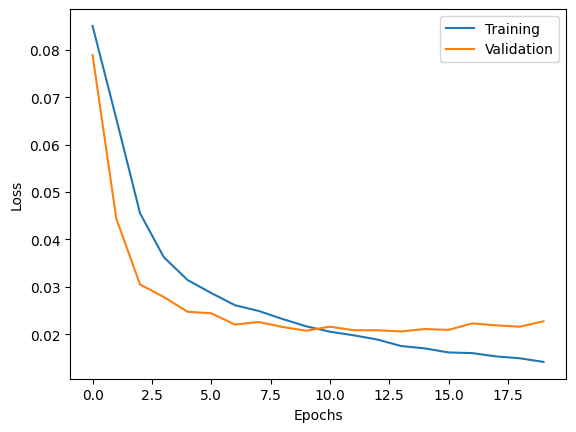

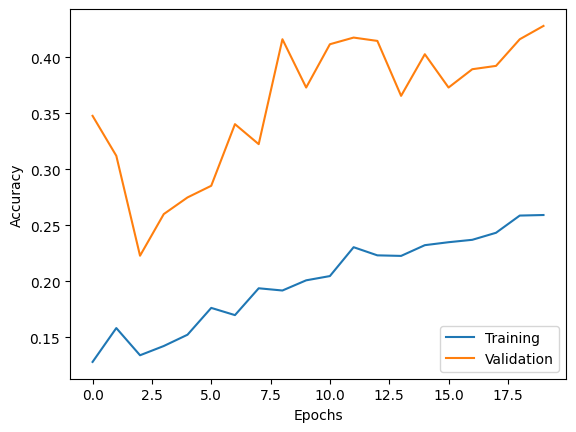

In [24]:
plot_history(hist)

In [25]:
print('Number of Parameters',CNN.count_params())
print('Final Training Loss',hist.history['loss'][-1])
print('Final Validation Loss',hist.history['val_loss'][-1])

Number of Parameters 100364
Final Training Loss 0.014171885326504707
Final Validation Loss 0.022740516811609268


Python code that evaluates the results on a (separate) test set,

In [26]:
print(CNN.evaluate(X_test, Y_test))

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2307 - loss: 0.0247
[0.02448020689189434, 0.24368499219417572]


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Horizon 1 months : RMSE: 0.008, MAE: 0.068
Horizon 2 months : RMSE: 0.012, MAE: 0.086
Horizon 3 months : RMSE: 0.015, MAE: 0.099
Horizon 4 months : RMSE: 0.019, MAE: 0.107
Horizon 5 months : RMSE: 0.022, MAE: 0.115
Horizon 6 months : RMSE: 0.025, MAE: 0.123
Horizon 7 months : RMSE: 0.028, MAE: 0.130
Horizon 8 months : RMSE: 0.029, MAE: 0.132
Horizon 9 months : RMSE: 0.032, MAE: 0.138
Horizon 10 months : RMSE: 0.034, MAE: 0.142
Horizon 11 months : RMSE: 0.034, MAE: 0.144
Horizon 12 months : RMSE: 0.036, MAE: 0.149


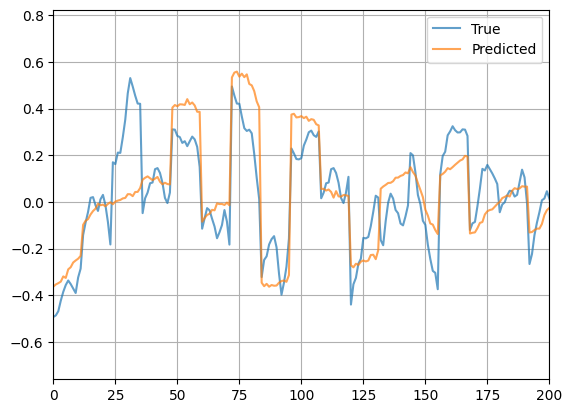

In [64]:
Y_pred = CNN.predict(X_test)
for h in np.arange(1,13,1):
    y_true_h = Y_test[:, h-1]
    y_pred_h = Y_pred[:, h-1]
    rmse = mean_squared_error(y_true_h, y_pred_h)
    mae = mean_absolute_error(y_true_h, y_pred_h)
    print(f"Horizon {h} months : RMSE: {rmse:.3f}, MAE: {mae:.3f}")

y_test_flat = Y_test.flatten()
y_pred_flat = Y_pred.flatten()

x = np.arange(len(y_test_flat))

plt.plot(x, y_test_flat, label='True', alpha=0.7)
plt.plot(x, y_pred_flat, label='Predicted', alpha=0.7)
plt.legend()
plt.xlim(0, 200)
plt.grid(True)
plt.show()

# CNN + LSTM Model

In [58]:
def create_cnn_lstm_model(input_shape=(9, 64, 96, 1), output_shape=12, weight_decay=1e-4, clipnorm=1.0):

    input_layer = layers.Input(shape=input_shape)

    # CNN
    cnn = layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay)))(input_layer)
    cnn = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(cnn)

    cnn = layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay)))(cnn)
    cnn = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(cnn)

    cnn = layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay)))(cnn)
    cnn = layers.TimeDistributed(layers.GlobalAveragePooling2D())(cnn)

    # LSTM
    lstm = layers.LSTM(64, return_sequences=False)(cnn)
    lstm = layers.Dropout(0.5)(lstm)

    output = layers.Dense(output_shape, activation='linear')(lstm)
    model = models.Model(inputs=input_layer, outputs=output)
    optimizer = optimizers.Adam(learning_rate=1e-3, clipnorm=clipnorm)
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

    return model

In [59]:
# format X
X_train_tranposed = np.transpose(X_train_stacked, (0, 3, 1, 2))
X_train_tranposed = np.expand_dims(X_train_tranposed, -1)
X_val_transposed = np.transpose(X_val, (0, 3, 1, 2))
X_val_transposed = np.expand_dims(X_val_transposed, -1)

# Run model
model = create_cnn_lstm_model(input_shape=X_train_tranposed.shape[1:], output_shape=12)
history = model.fit(X_train_tranposed, Y_train_stacked, validation_data=(X_val_transposed, Y_val),
                    epochs=20, batch_size=64, verbose=1)

Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 272s 3s/step - accuracy: 0.0946 - loss: 0.0762 - val_accuracy: 0.2065 - val_loss: 0.0400
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 310s 3s/step - accuracy: 0.1293 - loss: 0.0424 - val_accuracy: 0.3046 - val_loss: 0.0345
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.1743 - loss: 0.0355 - val_accuracy: 0.3611 - val_loss: 0.0304
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.1739 - loss: 0.0324 - val_accuracy: 0.4086 - val_loss: 0.0286
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.2070 - loss: 0.0291 - val_accuracy: 0.4101 - val_loss: 0.0284
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 248s 3s/step - accuracy: 0.2156 - loss: 0.0281 - val_accuracy: 0.4264 - val_loss: 0.0299
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.2559 - loss: 0.0259 - val_accuracy: 0.4042 - val_loss: 0.0296
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.2421 - loss: 0.0236 - val_accuracy: 0.3982 - v

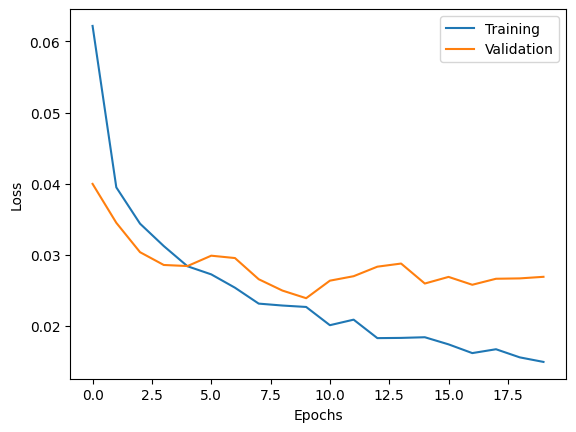

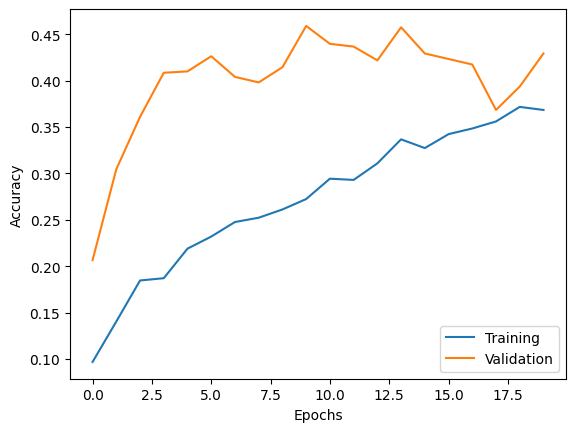

In [60]:
plot_history(history)

In [61]:
X_test_reshaped = np.transpose(X_test, (0, 3, 1, 2))
X_test_reshaped = np.expand_dims(X_test_reshaped, axis=-1)
print(model.evaluate(X_test_reshaped, Y_test))

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.2129 - loss: 0.0322
[0.03410351276397705, 0.2303120344877243]


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step
Horizon 1 months : RMSE: 0.010, MAE: 0.080
Horizon 2 months : RMSE: 0.013, MAE: 0.091
Horizon 3 months : RMSE: 0.016, MAE: 0.101
Horizon 4 months : RMSE: 0.020, MAE: 0.113
Horizon 5 months : RMSE: 0.024, MAE: 0.126
Horizon 6 months : RMSE: 0.029, MAE: 0.137
Horizon 7 months : RMSE: 0.033, MAE: 0.147
Horizon 8 months : RMSE: 0.037, MAE: 0.156
Horizon 9 months : RMSE: 0.041, MAE: 0.165
Horizon 10 months : RMSE: 0.046, MAE: 0.171
Horizon 11 months : RMSE: 0.049, MAE: 0.176
Horizon 12 months : RMSE: 0.052, MAE: 0.183


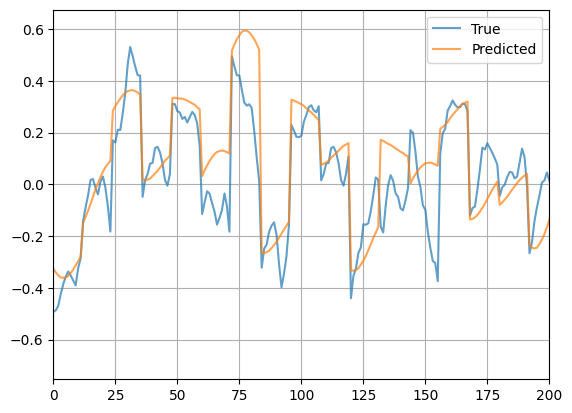

In [63]:
Y_pred = model.predict(X_test_reshaped)  # Y predicted

# calculate rmse and mae
for h in np.arange(1,13,1):
    y_true_h = Y_test[:, h-1]
    y_pred_h = Y_pred[:, h-1]
    rmse = mean_squared_error(y_true_h, y_pred_h)
    mae = mean_absolute_error(y_true_h, y_pred_h)
    print(f"Horizon {h} months : RMSE: {rmse:.3f}, MAE: {mae:.3f}")

y_test_flat = Y_test.flatten()
y_pred_flat = Y_pred.flatten()

x = np.arange(len(y_test_flat))

plt.plot(x, y_test_flat, label='True', alpha=0.7)
plt.plot(x, y_pred_flat, label='Predicted', alpha=0.7)
plt.legend()
plt.xlim(0, 200)
plt.grid(True)
plt.show()